In [48]:
import boto3
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import precision_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import pickle
import sklearn  # Añadir esta línea para importar sklearn

print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"Boto3 version: {boto3.__version__}")


Pandas version: 2.2.3
Numpy version: 2.1.3
Sklearn version: 1.5.2
Boto3 version: 1.35.74


In [49]:
load_dotenv()
# Configurar la conexión con S3 usando variables de entorno
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
    aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
)

bucket_name = 'chicago-inspections-analytics'
ingesta_inicial_key = 'feature-matrix/feature-matrix.2024-11-22.pkl'  # Ruta del archivo en S3

# Función para cargar el archivo de ingesta inicial desde S3
def cargar_feature_matrix():
    try:
        # Descargar el archivo de S3
        file_obj = s3_client.get_object(Bucket=bucket_name, Key=ingesta_inicial_key)
        file_data = file_obj['Body'].read()
        
        # Convertir el archivo de Pickle a un DataFrame
        df = pickle.loads(file_data)
        print("matriz de caracteristicas cargada exitosamente.")
        return df
    except Exception as e:
        print("Error al cargar la matriza de caracteristicas desde S3:", e)
        return None

# Cargar el DataFrame de ingesta inicial
df_inicial = cargar_feature_matrix()

# Obtener la fecha más reciente
if df_inicial is not None:
   df_inicial.head()
else:
    print("No se pudo cargar la matriz de carateriscticas.")

matriz de caracteristicas cargada exitosamente.


In [24]:
df_inicial.head()

,facility_type__facility_type_BANQUET HALL,facility_type__facility_type_Bakery,facility_type__facility_type_Catering,facility_type__facility_type_Children's Services Facility,facility_type__facility_type_GAS STATION,facility_type__facility_type_Golden Diner,facility_type__facility_type_Grocery Store,facility_type__facility_type_Hospital,facility_type__facility_type_Liquor,facility_type__facility_type_Long Term Care,...,remainder__latitude,remainder__longitude,remainder__results,remainder__month,remainder__year,remainder__day_of_month,remainder__week_of_year,remainder__week_day,remainder__weekend,remainder__day_of_week
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.884586,-87.63101,pass,1,2010,4,1,1,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.961606,-87.675967,pass,1,2010,4,1,1,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.961606,-87.675967,pass,1,2010,4,1,1,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.898431,-87.628009,fail,1,2010,4,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.938443,-87.768318,pass,1,2010,4,1,1,0,0


In [25]:
# Verificar si las columnas necesarias existen
columnas_fecha = ['remainder__year', 'remainder__month', 'remainder__day_of_month']
if set(columnas_fecha).issubset(df_inicial.columns):

    # Convertir las columnas a tipo numérico
    df_inicial[columnas_fecha] = df_inicial[columnas_fecha].apply(pd.to_numeric, errors='coerce')

    # Ordenar por año, mes y día de más antiguo a más reciente
    df_inicial = df_inicial.sort_values(by=['remainder__year', 'remainder__month', 'remainder__day_of_month'])

    # Separar características (X) y variable objetivo (y)
    X = df_inicial.drop(columns=['remainder__results'])  # Eliminar la variable objetivo
    y = df_inicial['remainder__results']  # Variable objetivo

    # Dividir en 70% entrenamiento y 30% prueba sin aleatorización, usando la semilla
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20201122, shuffle=False)

    print("Datos separados correctamente y ordenados.")
else:
    print("Error: No se encontraron todas las columnas necesarias para ordenar los datos.")


Datos separados correctamente y ordenados.


In [ ]:
# Configurar la conexión con S3
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
    aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
)

# Función para guardar un archivo en S3
def guardar_en_s3(data, bucket_name, path):
    try:
        # Convertir el dataframe a pickle
        pickle_data = pickle.dumps(data)

        # Subir el archivo al bucket S3
        s3_client.put_object(Bucket=bucket_name, Key=path, Body=pickle_data)
        print(f"Archivo guardado correctamente en {bucket_name}/{path}")
    except Exception as e:
        print(f"Error al guardar el archivo en S3: {e}")

# Guardar el conjunto de entrenamiento
train_path = 'dataset/train/train_dataset.pkl'
train_target_path = 'dataset/train/train_target.pkl'

guardar_en_s3(X_train, bucket_name, train_path)
guardar_en_s3(y_train, bucket_name, train_target_path)

# Guardar el conjunto de pruebas
test_path = 'dataset/test/test_dataset.pkl'
test_target_path = 'dataset/test/test_target.pkl'

guardar_en_s3(X_test, bucket_name,test_path)
guardar_en_s3(y_test, bucket_name, test_target_path)


Archivo guardado correctamente en chicago-inspections-analytics/dataset/train/train_dataset.pkl
Archivo guardado correctamente en chicago-inspections-analytics/dataset/test/test_dataset.pkl


In [28]:
# Definir el modelo base de Árbol de Decisión
dt = DecisionTreeClassifier()

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'max_depth': [5, 7, 9,11,15],  # Profundidad máxima del árbol
    'min_samples_leaf': [5,7,9,11,13],  # Mínimo de muestras por hoja
    'criterion': ['gini', 'entropy']  # Criterio de ganancia de información
}

# Configuración de TimeSeriesSplit (5 pliegues)
tscv = TimeSeriesSplit(n_splits=5)

# Configurar GridSearchCV con precisión como métrica de evaluación
grid_search = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=tscv, 
    scoring='precision',  # Métrica de precisión
    n_jobs=-1, 
    verbose=1
)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Obtener el mejor modelo
best_dt_model = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred = best_dt_model.predict(X_test)

# Calcular la precisión en el conjunto de prueba
print(f"Precisión en conjunto de prueba: {precision_score(y_test, y_pred, pos_label='pass')}")

# Función para guardar el modelo en un bucket de S3 usando pickle
def save_model(model, bucket_name, model_name):
    # Guardar el modelo localmente como un archivo pickle
    model_filename = f"{model_name}.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)

    # Subir el archivo pickle al bucket de S3
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )

    s3_client.upload_file(model_filename, bucket_name, f"modelos/{model_filename}")
    print(f"Modelo guardado en S3 en: {bucket_name}/modelos/{model_filename}")
save_model(best_dt_model, bucket_name, "arboles_gridsearch")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/antonio/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/antonio/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/antonio/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/antonio/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/antonio/miniconda3/lib/python3.12/s

Mejores parámetros encontrados: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}
Precisión en conjunto de prueba: 0.7481371777664646
Modelo guardado en S3 en: chicago-inspections-analytics/modelos/arboles_gridsearch.pkl


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import precision_score, make_scorer

# Definir el modelo base
rf = RandomForestClassifier()

# Definir los hiperparámetros a ajustar
param_grid = {
    'max_depth': [5, 7, 9, 13],  # Opciones de profundidad máxima
    'min_samples_leaf': [5, 9, 11],  # Opciones de cantidad mínima de muestras por hoja
    'n_estimators': [300, 500, 800, 1000, 1300]  # Opciones de número de estimadores
}

# Configuración de TimeSeriesSplit (5 pliegues)
tscv = TimeSeriesSplit(n_splits=5)

# Usar make_scorer para especificar 'precision' como métrica de evaluación
precision_scorer = make_scorer(precision_score, pos_label='pass')

# Configuración de GridSearchCV con TimeSeriesSplit y precisión como métrica de evaluación
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring=precision_scorer,  # Usar precisión como métrica de selección
    n_jobs=-1,  # Ejecutar en un solo hilo
    verbose=1
)

# Entrenar el modelo con GridSearchCV
print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred = best_rf_model.predict(X_test)

# Imprimir precisión en el conjunto de prueba
print(f"Precisión en conjunto de prueba: {precision_score(y_test, y_pred, pos_label='pass')}")

# Guardar el modelo entrenado en el bucket de S3 (si es necesario)
save_model(best_rf_model, bucket_name, "Random_forest")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mejores parámetros encontrados: {'max_depth': 13, 'min_samples_leaf': 5, 'n_estimators': 1300}
Precisión en conjunto de prueba: 0.7480793557742742
Modelo guardado en S3 en: chicago-inspections-analytics/modelos/Random_forest.pkl


In [44]:
# Definir el modelo base de regresión logística
log_reg = LogisticRegression(solver='liblinear')  # El solver 'liblinear' es adecuado para penalización L1

# Configuración de la búsqueda de cuadrícula con los hiperparámetros que mencionas
param_grid = {
    'penalty': ['l2', 'none'],  # Penalización L2 o sin penalización
    'max_iter': [300, 500, 1000],  # Número de iteraciones
    'solver': ['liblinear']  # Solver adecuado para las penalizaciones L1 y L2
}

# Configuración de TimeSeriesSplit (5 pliegues)
tscv = TimeSeriesSplit(n_splits=5)

# Configuración de GridSearchCV con precisión como la métrica de evaluación
precision_scorer = make_scorer(precision_score, pos_label='pass')

grid_search = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid, 
    cv=tscv, 
    scoring=precision_scorer,  # Métrica de precisión
    n_jobs=-1, 
    verbose=1
)

# Entrenar el modelo con GridSearchCV (usando el conjunto de entrenamiento)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Obtener el mejor modelo
best_log_reg_model = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred = best_log_reg_model.predict(X_test)

# Imprimir precisión en el conjunto de prueba
# Cambiar el valor de pos_label a 'pass'
print(f"Precisión en conjunto de prueba: {precision_score(y_test, y_pred, pos_label='pass')}")

# Guardar el modelo entrenado en el bucket de S3
save_model(best_log_reg_model, bucket_name, 'logisticregression_gridsearch')


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/antonio/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/antonio/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/antonio/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/antonio/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "

Mejores parámetros encontrados: {'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}
Precisión en conjunto de prueba: 0.7480949001943664
Modelo guardado en S3 en: chicago-inspections-analytics/modelos/logisticregression_gridsearch.pkl


## Evaluación y selección de modelos

In [1]:
import boto3
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [18]:
def load_model(bucket_name, model_path):
    """
    Descarga un modelo desde S3 y lo carga en memoria.
    """
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )
    obj = s3_client.get_object(Bucket=bucket_name, Key=model_path)
    return pickle.loads(obj['Body'].read())


In [37]:

def plot_roc_curve(model, X_test, y_test):
    """
    Genera la curva ROC y calcula el AUC de un modelo dado.
    """
    y_scores = model.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC del Modelo')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return roc_auc


In [5]:
def generate_metrics_table(model, X_test, y_test):
    """
    Calcula métricas de evaluación incluyendo TNR, FNR, precisión, recall y f1-score.
    """
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    metrics_df = pd.DataFrame({
        'threshold': thresholds,
        'precision': precision[:-1],
        'recall': recall[:-1],
        'f1_score': f1_scores[:-1]
    })
    metrics_df['tnr'] = 1 - metrics_df['recall']  # True Negative Rate (1 - Recall)
    metrics_df['fnr'] = 1 - metrics_df['precision']  # False Negative Rate
    
    return metrics_df

In [6]:
def save_metrics_to_s3(metrics_df, bucket_name, model_name):
    """
    Guarda la tabla de métricas en un pickle en S3.
    """
    s3 = boto3.client('s3')
    pickle_data = pickle.dumps(metrics_df)
    path = f"evaluacion/metricas_{model_name}.pkl"
    s3.put_object(Bucket=bucket_name, Key=path, Body=pickle_data)


In [64]:

def get_metrics(bucket_name, path):
    """
    Descarga las métricas de un modelo desde S3 y las carga en memoria.
    """


    load_dotenv()
    # Configurar la conexión con S3 usando variables de entorno
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )
    obj = s3_client.get_object(Bucket=bucket_name, Key=path)
    return pickle.loads(obj['Body'].read())

In [72]:
def select_best_model(recall_min, lista_metricas):
    """
    Selecciona el mejor modelo basado en el recall mínimo requerido.

    Parámetros:
    - recall_min: Valor mínimo de recall permitido.
    - lista_metricas: Lista de archivos de métricas a evaluar.

    Retorna:
    - Tupla con (nombre_modelo, threshold, precision, recall, f1_score) del mejor modelo.
    """
    best_tuple = None
    best_f1 = -np.inf
    
    # Obtener las métricas de cada modelo
    metrics_list = [get_metrics(bucket_name, f"modelos/evaluacion/{metrica}") for metrica in lista_metricas]  
    
    for idx, metrics in enumerate(metrics_list):
        # Validar las métricas
        valid_metrics = metrics[metrics['recall'] >= recall_min]
        if not valid_metrics.empty:
            best_candidate = valid_metrics.loc[valid_metrics['f1_score'].idxmax()]
            if best_candidate['f1_score'] > best_f1:
                best_f1 = best_candidate['f1_score']
                # Obtener el nombre del modelo desde la lista de métricas (nombre de archivo)
                model_name = lista_metricas[idx]
                # Devolver el nombre del modelo junto con las métricas
                best_tuple = (model_name, *tuple(best_candidate[['threshold', 'precision', 'recall', 'f1_score']]))
    
    return best_tuple

# Llamada a la función
mejor_modelo = select_best_model(0.8, ["metricas_arbol.pkl", "metricas_random_forest.pkl", "metricas_regresion_logistica.pkl"])
print(mejor_modelo)


('metricas_arbol.pkl', 0.5691906005221932, 0.7481371777664646, 0.9999793797426592, 0.8559174699693552)


In [79]:
def save_threshold_best_model(bucket_name, best_threshold_tuple):
    """
    Guarda la tupla del mejor umbral en S3.
    """
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )
    pickle_data = pickle.dumps(best_threshold_tuple)
    path = "best_model/threshold.pkl"
    s3_client.put_object(Bucket=bucket_name, Key=path, Body=pickle_data)


In [84]:
def save_best_model(bucket_name, model, model_path):
    """
    Guarda el modelo seleccionado en S3.
    """
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )

    pickle_data = pickle.dumps(model)
    s3_client.put_object(Bucket=bucket_name, Key=model_path, Body=pickle_data)


In [62]:
bucket_name = 'chicago-inspections-analytics'

arboles=load_model(bucket_name, "modelos/arboles_gridsearch.pkl")

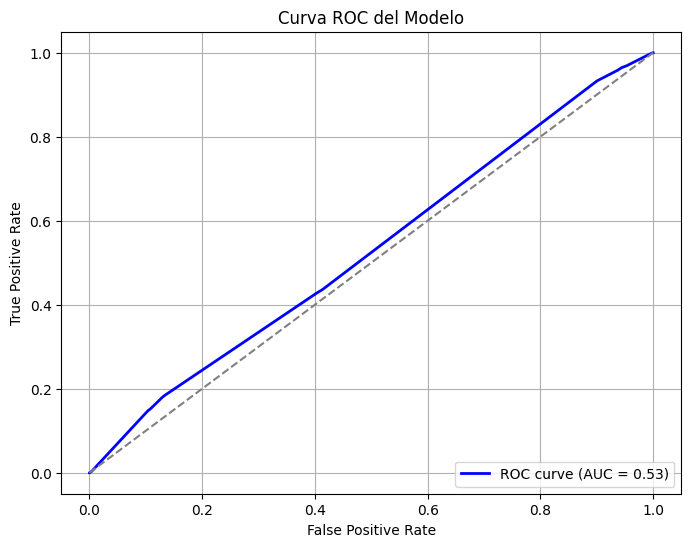

np.float64(0.5290179878346289)

In [42]:
encoder = LabelEncoder()
y_test_numeric = encoder.fit_transform(y_test)
plot_roc_curve(arboles, X_test, y_test_numeric)


In [56]:
def save_metrics_to_s3(model_paths, X_test, y_test, bucket_name, save_paths):
    """
    Carga modelos desde S3, genera métricas y las guarda en S3.
    
    Parámetros:
    - model_paths: Diccionario con nombres de modelos y sus rutas en S3.
    - X_test, y_test: Datos de prueba.
    - bucket_name: Nombre del bucket en S3.
    - save_paths: Diccionario con nombres de modelos y sus rutas de guardado en S3.
    """
    for model_name, model_path in model_paths.items():
        model = load_model(bucket_name, model_path)
        metricas = generate_metrics_table(model, X_test, y_test)
        guardar_en_s3(metricas, bucket_name, save_paths[model_name])

# Definir rutas de modelos y guardado
bucket_name = 'chicago-inspections-analytics'
model_paths = {
    "arboles": "modelos/arboles_gridsearch.pkl",
    "RandomForest": "modelos/Random_forest.pkl",
    "Regresion_Logistica": "modelos/logisticregression_gridsearch.pkl"
}
save_paths = {
    "arboles": "modelos/evaluacion/metricas_arbol.pkl",
    "RandomForest": "modelos/evaluacion/metricas_random_forest.pkl",
    "Regresion_Logistica": "modelos/evaluacion/metricas_regresion_logistica.pkl"
}


In [57]:
save_metrics_to_s3(model_paths, X_test, y_test_numeric, bucket_name, save_paths)


Archivo guardado correctamente en chicago-inspections-analytics/modelos/evaluacion/metricas_arbol.pkl
Archivo guardado correctamente en chicago-inspections-analytics/modelos/evaluacion/metricas_random_forest.pkl
Archivo guardado correctamente en chicago-inspections-analytics/modelos/evaluacion/metricas_regresion_logistica.pkl


In [75]:
mejor_modelo = select_best_model(0.9, ["metricas_arbol.pkl", "metricas_random_forest.pkl", "metricas_regresion_logistica.pkl"])
print(mejor_modelo)
print(type(mejor_modelo))

('metricas_arbol.pkl', 0.5691906005221932, 0.7481371777664646, 0.9999793797426592, 0.8559174699693552)
<class 'tuple'>


In [80]:
print(mejor_modelo[0])
save_threshold_best_model("chicago-inspections-analytics",mejor_modelo[1:])

metricas_arbol.pkl


In [88]:
save_best_model("chicago-inspections-analytics", arboles, "selected-model/select_model.pkl")
